In [31]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps
import pandas as pd
from scipy import stats

from utils.gpu.cuda_cluster import *
from utils.gpu.preprocessing import read_data, factorize_small_cardinality

import core.config as conf


In [2]:
client

Client Scheduler: tcp://127.0.0.1:37347 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


## 1. Load Data

In [3]:
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00175'
ori_df = read_data(data_path)

In [4]:
ori_df.columns

Index(['text_ tokens', 'hashtags', 'tweet_id', 'present_media',
       'present_links', 'present_domains', 'tweet_type', 'language',
       'tweet_timestamp', 'engaged_with_user_id',
       'engaged_with_user_follower_count', 'engaged_with_user_following_count',
       'engaged_with_user_is_verified', 'engaged_with_user_account_creation',
       'enaging_user_id', 'enaging_user_follower_count',
       'enaging_user_following_count', 'enaging_user_is_verified',
       'enaging_user_account_creation', 'engagee_follows_engager',
       'reply_timestamp', 'retweet_timestamp',
       'retweet_with_comment_timestamp', 'like_timestamp'],
      dtype='object')

In [5]:
df = ori_df[['engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaged_with_user_account_creation', 'enaging_user_follower_count', 'enaging_user_following_count', 'enaging_user_account_creation', 'reply_timestamp', 'retweet_timestamp', 'retweet_with_comment_timestamp', 'like_timestamp']]

In [6]:
df = df.rename(columns = {'engaged_with_user_follower_count' : 'creator_follower_count', 'engaged_with_user_following_count' : 'creator_following_count', 'engaged_with_user_account_creation' : 'creator_account_creation', 'enaging_user_follower_count' : 'engager_following_count', 'enaging_user_following_count' : 'engager_follower_count', 'enaging_user_account_creation' : 'engager_account_creation'})

In [7]:
df['is_reply'] = df['reply_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_retweet'] = df['retweet_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_comment'] = df['retweet_with_comment_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_like'] = df['like_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)

df['is_positive'] = df[['is_like', 'is_retweet', 'is_reply', 'is_comment']].sum(axis=1).astype(np.uint8)
df['is_negative'] =  df['is_positive'].compute().applymap(lambda x: 1 if x == 0 else 0).astype(np.int32)

df = df.drop('reply_timestamp', axis=1)
df = df.drop('retweet_timestamp', axis=1)
df = df.drop('retweet_with_comment_timestamp', axis=1)
df = df.drop('like_timestamp', axis=1)

In [8]:
df.head()

,creator_follower_count,creator_following_count,creator_account_creation,engager_following_count,engager_follower_count,engager_account_creation,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative
id,,,,,,,,,,,,
1,4753,1060,1423752135,76,189,1435892882,0,0,0,1,1,0
2,110643,180,1419491382,260,379,1393057295,0,0,0,0,0,1
3,4480,2953,1590589531,1259,868,1587102370,1,0,0,0,1,0
4,461,157,1492957625,437,597,1419347918,0,0,0,1,1,0
5,1308,1478,1347572499,247,404,1507470713,0,0,0,0,0,1


## 2. Creator Account Creation Group

In [9]:
df["creator_account_creation"].unique().compute()

0            -4665600
1          1138308614
2          1138308703
3          1138309452
4          1139196690
              ...    
1554709    1608246213
1554710    1608246288
1554711    1608249056
1554712    1608249262
1554713    1608249473
Name: creator_account_creation, Length: 1554714, dtype: int32

In [36]:
ps_df = df[df["is_positive"] == 1]
ng_df = df[df["is_negative"] == 1]

In [38]:
ps_account_df = ps_df.groupby("creator_account_creation").sum()
ng_account_df = ng_df.groupby("creator_account_creation").sum()

In [40]:
ps_account_df = ps_account_df.compute().sort_index()
ng_account_df = ng_account_df.compute().sort_index()

In [46]:
stats.describe(ps_account_df['is_positive'].to_array())

DescribeResult(nobs=778969, minmax=(1, 1496), mean=1.8551007806472402, variance=54.69133640318115, skewness=59.98988343473391, kurtosis=6253.40035973159)

In [47]:
stats.describe(ng_account_df['is_negative'].to_array())

DescribeResult(nobs=929611, minmax=(1, 1080), mean=1.6345901672850256, variance=26.519384795059096, skewness=53.86522019631677, kurtosis=5678.052344656905)

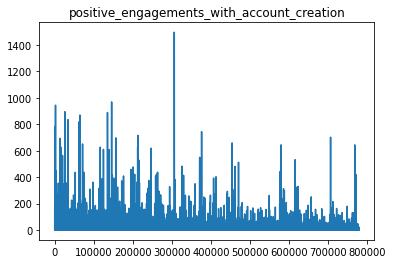

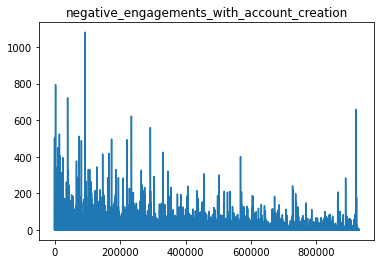

In [65]:
plt.title('positive_engagements_with_account_creation')
plt.plot(range(len(ps_account_df.index)), ps_account_df['is_positive'].to_array())
plt.show()

plt.title('negative_engagements_with_account_creation')
plt.plot(range(len(ng_account_df.index)), ng_account_df['is_negative'].to_array())
plt.show()

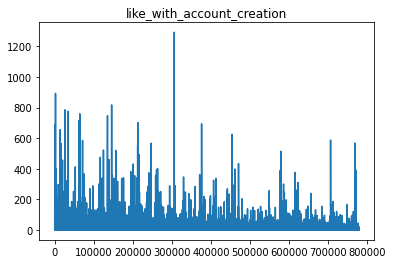

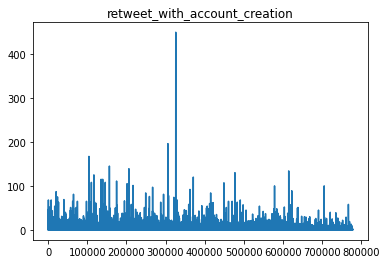

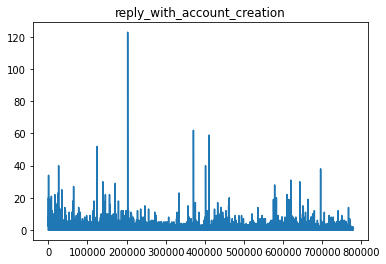

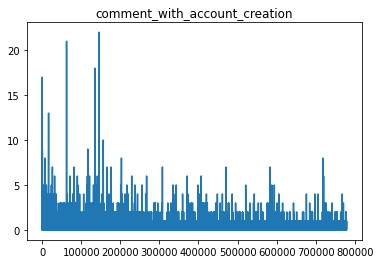

In [48]:
plt.title('like_with_account_creation')
plt.plot(range(len(ps_account_df.index)), ps_account_df['is_like'].to_array())
plt.show()

plt.title('retweet_with_account_creation')
plt.plot(range(len(ps_account_df.index)), ps_account_df['is_retweet'].to_array())
plt.show()

plt.title('reply_with_account_creation')
plt.plot(range(len(ps_account_df.index)), ps_account_df['is_reply'].to_array())
plt.show()

plt.title('comment_with_account_creation')
plt.plot(range(len(ps_account_df.index)), ps_account_df['is_comment'].to_array())
plt.show()


In [26]:
ps_df.groupby(by=["creator_account_creation", "creator_follower_count"]).sum().compute()

,,creator_following_count,engager_following_count,engager_follower_count,engager_account_creation,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative
creator_account_creation,creator_follower_count,,,,,,,,,,
1525304931,143,120,272,284,1572256686,0,0,0,1,1,0
1378414617,975,257,972,118,1369096421,0,1,0,0,1,0
1576175369,141,504,30,98,1580502012,0,0,0,1,1,0
1340554000,25297,488,1668,510,1537391731,0,0,0,1,1,0
1482191231,404,722,314,731,3011409385,0,0,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...
1585393623,2830,2495,244,351,1592094961,1,0,0,0,1,0
1571364015,216,237,80,197,1586254055,0,0,0,1,1,0
1482702208,16909,12082,5604,4609,1498388012,0,0,0,1,1,0


## 3. Relation between account creation and follower/following

In [61]:
ps_df = ps_df.sort_values(by=['creator_account_creation'], axis=0)

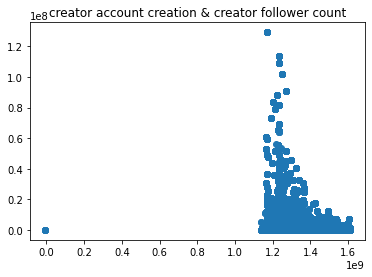

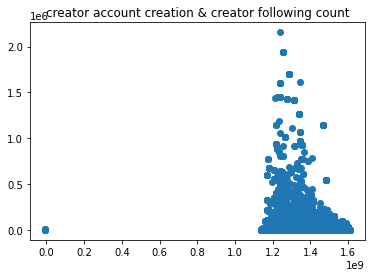

In [64]:
plt.title('creator account creation & creator follower count')
plt.scatter(ps_df['creator_account_creation'].compute().to_array(), ps_df['creator_follower_count'].compute().to_array())
plt.show()

plt.title('creator account creation & creator following count')
plt.scatter(ps_df['creator_account_creation'].compute().to_array(), ps_df['creator_following_count'].compute().to_array())
plt.show()

## 4. Analysis recent account creation

In [129]:
# 2020.01 ~
recent_ac = df[df["creator_account_creation"] >= 1577804400]

In [130]:
r_ps_df = recent_ac[recent_ac["is_positive"] == 1]
r_ng_df = recent_ac[recent_ac["is_negative"] == 1]

In [131]:
r_ps_account_df = r_ps_df.groupby("creator_account_creation").sum()
r_ng_account_df = r_ng_df.groupby("creator_account_creation").sum()

In [132]:
r_ps_account_df = r_ps_account_df.compute().sort_index()
r_ng_account_df = r_ng_account_df.compute().sort_index()

In [133]:
stats.describe(r_ps_account_df['is_positive'].to_array())

DescribeResult(nobs=173714, minmax=(1, 702), mean=1.5634779004570731, variance=18.749307934303474, skewness=74.37949561315128, kurtosis=9243.47613910331)

In [134]:
stats.describe(r_ng_account_df['is_negative'].to_array())

DescribeResult(nobs=171955, minmax=(1, 659), mean=1.24222616382193, variance=5.999504494367616, skewness=137.55611559584406, kurtosis=32146.674845738024)

In [135]:
# except outlier
r_ps_account_df = r_ps_account_df[r_ps_account_df["is_positive"] <= 300]
r_ng_account_df = r_ng_account_df[r_ng_account_df["is_negative"] <= 100]

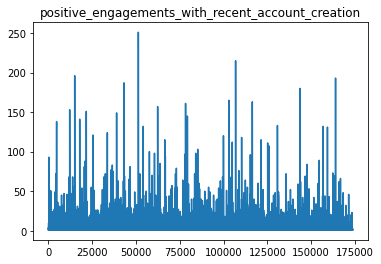

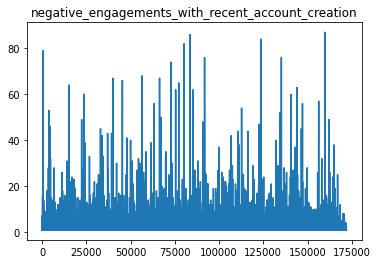

In [136]:
plt.title('positive_engagements_with_recent_account_creation')
plt.plot(range(len(r_ps_account_df.index)), r_ps_account_df['is_positive'].to_array())
plt.show()

plt.title('negative_engagements_with_recent_account_creation')
plt.plot(range(len(r_ng_account_df.index)), r_ng_account_df['is_negative'].to_array())
plt.show()